<a href="https://colab.research.google.com/github/NofarSachs/tissue_stiffness_dinov2/blob/main/Stiffness_prediction_DinoV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Data loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

path_to_zip = "/content/drive/My Drive/images and stiffnesses (2).zip"

with zipfile.ZipFile(path_to_zip, "r") as zip_ref:
    zip_ref.extractall(".")

**Data preprocessing**

In [ ]:
import random
import math
from torchvision import transforms

class RotateBoth:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, sample):
        image, stiffness_vector = sample
        angle = random.uniform(self.degrees[0], self.degrees[1])
        rotated_image = transforms.functional.rotate(image, angle)

        # Assuming stiffness_vector is a 2D vector, we need to rotate it by the same angle
        # Convert angle to radians and create a rotation matrix
        angle_rad = math.radians(angle)
        rotation_matrix = torch.tensor([
            [math.cos(angle_rad), -math.sin(angle_rad)],
            [math.sin(angle_rad), math.cos(angle_rad)]
        ], dtype=torch.float)

        rotated_stiffness_vector = torch.matmul(rotation_matrix, stiffness_vector)

        return rotated_image, rotated_stiffness_vector



# Define data augmentation transformations
# We will compose our own transformation pipeline, including the RotateBoth transformation
class CustomTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
            # transforms.RandomCrop(size=(224, 224), padding=None, padding_mode='reflect'),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.rotate_both = RotateBoth(degrees=(-15, 15))

    def __call__(self, image, stiffness_vector):
        image, stiffness_vector = self.rotate_both((image, stiffness_vector))
        image = self.transforms(image)
        return image, stiffness_vector


transforms_pipeline = CustomTransform()

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
from torch.utils.data import ConcatDataset
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoImageProcessor


class CustomDataset(Dataset):
    def __init__(self, root_dir, csv_files, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.csv_files = csv_files
        self.data = self.combine_csv()

    def combine_csv(self):
        combined_data = pd.DataFrame()
        for csv_file in self.csv_files:
            data = pd.read_csv(csv_file)
            combined_data = pd.concat([combined_data, data], ignore_index=True)
        return combined_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(int(self.data.iloc[idx, 0])) + ".png")

        # Check if image file exists
        if not os.path.exists(img_name):
            print(f"Image file {img_name} not found. Skipping...")
            return None

        image = Image.open(img_name)
        label = self.data.iloc[idx, 2:].values.astype('float')
        label = torch.tensor(label, dtype=torch.float)


        if self.transform:
            image, label = self.transform(image, label)


        return np.array(image), label





# Paths to directories
data_dir = "images and stiffnesses"

# Collect CSV files in each subdirectory
subdirs = os.listdir(data_dir)
csv_files_list = []
for subdir in subdirs:
    subdir_path = os.path.join(data_dir, subdir)
    csv_files = [os.path.join(subdir_path, file) for file in os.listdir(subdir_path) if file.endswith('.csv')]
    csv_files_list.append(csv_files)

# Create train and test datasets for each directory
train_datasets = []
test_datasets = []
for subdir, csv_files in zip(subdirs, csv_files_list):
    subdir_path = os.path.join(data_dir, subdir)

    dataset = CustomDataset(root_dir=subdir_path, csv_files=csv_files, transform=transforms_pipeline)

    # Filter out None values (missing images)
    dataset.data = dataset.data.dropna()

    train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

    train_datasets.append(train_data)
    test_datasets.append(test_data)

# Concatenate train and test datasets from all directories
all_train_datasets = ConcatDataset(train_datasets)
all_test_datasets = ConcatDataset(test_datasets)

# Create data loaders for the combined datasets
all_train_loader = DataLoader(all_train_datasets, batch_size=64, shuffle=True)
all_test_loader = DataLoader(all_test_datasets, batch_size=64, shuffle=False)


**Testing Transformed data**

Combined Train dataset size: 192
Combined Test dataset size: 50
Batch 1: Data shape: torch.Size([64, 3, 224, 224]), Target shape: torch.Size([64, 2])


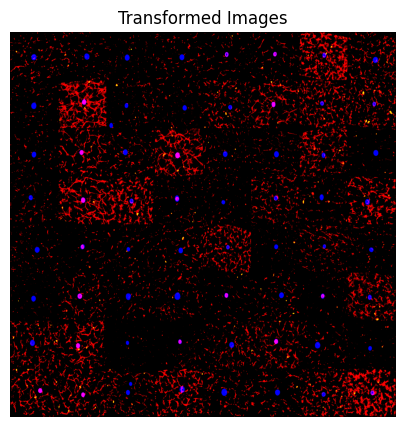

Batch 1: Data shape: torch.Size([50, 3, 224, 224]), Target shape: torch.Size([50, 2])


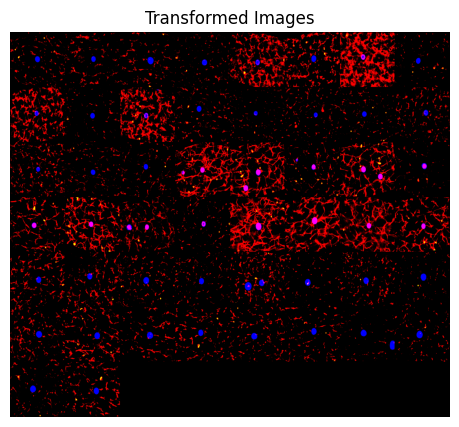

In [ ]:
# Function to display images from a batch
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(10, 5))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()


# Example usage
print("Combined Train dataset size:", len(all_train_loader.dataset))
print("Combined Test dataset size:", len(all_test_loader.dataset))

for batch_idx, (data, target) in enumerate(all_train_loader):
    # Your combined training loop goes here
    print(f"Batch {batch_idx + 1}: Data shape: {data.shape}, Target shape: {target.shape}")
    # Display only the first batch
    if batch_idx == 0:
        # Display images
        imshow(torchvision.utils.make_grid(data), title='Transformed Images')
        break

for batch_idx, (data, target) in enumerate(all_test_loader):
    # Your combined testing loop goes here
    print(f"Batch {batch_idx + 1}: Data shape: {data.shape}, Target shape: {target.shape}")
    # Display only the first batch
    if batch_idx == 0:
        # Display images
        imshow(torchvision.utils.make_grid(data), title='Transformed Images')
        break


**Model defintions**

**Dino V2 model**

In [ ]:
import torch.nn as nn
from transformers import AutoModel

dino_model_name = "facebook/dinov2-base"

class CustomDinoV2Model(nn.Module):
    def __init__(self, model_name, D = 0.3):
        super().__init__()
        self.name = model_name.replace('/','_')
        self.dino_model = AutoModel.from_pretrained(model_name)

        # Freeze the pre-trained model's encoder (optional, adjust based on experiment results)
        for param in self.dino_model.parameters():
            param.requires_grad = False

        num_features = self.dino_model.config.hidden_size
        print(num_features)
        self.custom_head = nn.Sequential(
            nn.Linear(num_features, num_features),  # First linear layer
            nn.Dropout(D),
            nn.ReLU(),  # Non-linear activation (ReLU)
            nn.Dropout(D),
            nn.Linear(num_features, num_features // 2),  # Second linear layer with reduced output size
            nn.ReLU(),  # Non-linear activation (ReLU)
            nn.Dropout(D),
            nn.Linear(num_features // 2, 2)  # Third linear layer for final prediction
        )

    def forward(self, images, input_ids=None, attention_mask=None, inputs_embeds=None, output_attentions=None, output_hidden_states=None, return_dict=None):
    # def forward(self, images):
        # Forward pass through DINO model
        model_output = self.dino_model(images)
        # Use the last hidden state (assuming that's what you want to use)
        hidden_states = model_output.last_hidden_state
        # Assuming we are using the [CLS] token representation
        cls_representation = hidden_states[:, 0]  # Take the first token ([CLS]) from the batch
        # Forward pass through the custom head
        print(cls_representation)
        stiffness_output = self.custom_head(cls_representation)
        return stiffness_output

    def unfreeze_params(self):
        for param in self.dino_model.parameters():
            param.requires_grad = True

    def freeze_params(self):
        for param in self.dino_model.parameters():
            param.requires_grad = False



In [ ]:
dino = CustomDinoV2Model("facebook/dinov2-base")
x  = []
y = []
x, y = train_model(dino, x, y, num_epochs=1)


768
Epoch: 1: 
tensor([[ 1.1912,  1.3385,  3.2096,  ..., -1.6690, -0.9806, -2.7729],
        [ 1.8367,  2.7613,  2.4085,  ..., -1.4249,  0.3633, -3.3984],
        [ 1.7926,  2.6557,  2.2743,  ..., -1.5413, -0.0754, -2.5718],
        ...,
        [ 0.7620,  1.8343,  2.8900,  ..., -1.3309, -0.4924, -2.5466],
        [ 0.1586,  2.1598,  2.7256,  ..., -0.8084,  0.0816, -2.9327],
        [ 1.1370,  1.8032,  2.3248,  ..., -0.2511, -0.1720, -3.1249]])
tensor([[ 0.4224,  1.0538,  2.5558,  ..., -2.1243, -0.0114, -2.8366],
        [ 0.0174,  1.4146,  1.6088,  ..., -0.5972, -0.6872, -2.5642],
        [ 0.3161,  2.0622,  2.5925,  ..., -1.2678, -0.3940, -2.9542],
        ...,
        [ 1.1322,  1.7954,  2.9029,  ..., -1.0656, -0.1993, -2.4613],
        [ 0.6963,  1.7796,  2.4279,  ..., -1.3973, -0.1115, -3.1498],
        [ 0.5109,  2.1141,  2.0805,  ..., -0.4890,  0.4928, -3.3504]])
tensor([[ 0.2150,  1.4989,  2.7041,  ..., -0.5794,  0.1891, -2.7136],
        [ 1.4312,  2.1602,  1.8907,  ..., -1.58

**vit-base-patch16-224 model**

In [ ]:
import torch.nn as nn
from transformers import AutoModel

class CustomViTModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        D=0.5
        self.name = model_name.replace('/','_')
        self.vit_model = AutoModel.from_pretrained(model_name)
        # Freeze the pre-trained model's encoder (optional)
        for param in self.vit_model.parameters():
            param.requires_grad = False
        num_features = self.vit_model.config.hidden_size
        self.custom_head = nn.Sequential(
            nn.Linear(num_features, num_features),  # First linear layer
            nn.Dropout(D),
            nn.ReLU(),  # Non-linear activation (ReLU)
            nn.Dropout(D),
            nn.Linear(num_features, num_features // 2),  # Second linear layer with reduced output size
            nn.ReLU(),  # Non-linear activation (ReLU)
            nn.Dropout(D),
            nn.Linear(num_features // 2, 2)  # Third linear layer for final prediction
        )

    def forward(self, images, input_ids=None, attention_mask=None, inputs_embeds=None, output_attentions=None, output_hidden_states=None, return_dict=None):
        model_output = self.vit_model(images)
        hidden_states = model_output.last_hidden_state
        cls_representation = hidden_states[:, 0]
        stiffness_output = self.custom_head(cls_representation)
        return stiffness_output

    def unfreeze_params(self):
        for param in self.vit_model.parameters():
            param.requires_grad = True


vit_model_name = "google/vit-base-patch16-224"
vit_model = CustomViTModel(vit_model_name)

vit_trn_losses = []
vit_vld_losses = []

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Training sequence**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, trn_losses, vld_losses, num_epochs):
    # Transfer the model to GPU if available
    model = model.to(device)

    # Define loss function
    criterion = nn.MSELoss()

    # Set up optimizer (adjust hyperparameters as needed)
    learning_rate = 0.0001
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}: ")
        model.train()
        train_loss = 0.0

        for images, stiffness_vectors in all_train_loader:
            images = images.to(device)
            stiffness_vectors = stiffness_vectors.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, stiffness_vectors).float()
            train_loss += loss.item()

            # Backward pass and update weights
            loss.backward()
            optimizer.step()

        # Evaluate on validation set (optional)
        model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for images, stiffness_vectors in all_test_loader:
                images = images.to(device)
                stiffness_vectors = stiffness_vectors.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, stiffness_vectors).item()

            trn_losses.append(train_loss/len(all_train_loader))
            vld_losses.append(val_loss/len(all_test_loader))
            print(f"Train Loss: {train_loss/len(all_train_loader):.4f}, Val Loss: {val_loss/len(all_test_loader):.4f}")


    # Save the fine-tuned model (optional)
    torch.save(model.state_dict(), (model.name + ".pt"))
    return trn_losses, vld_losses

**Plotting**

In [ ]:
def plot(trn_losses, vld_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(trn_losses, label='Training Loss')
    plt.plot(vld_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs. Epochs')
    plt.show()


**Train using LORA:**

In [ ]:
!pip install peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 10.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-many

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from peft import LoraConfig, TaskType, get_peft_model

# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model_lora(model, trn_losses, vld_losses, num_epochs, ver, target_modules = None, modules_to_save = None, lora_dropout = 0.1):
    # Transfer the model to GPU if available
    model = model.to(device)

    # Define loss function
    criterion = nn.MSELoss()


    # LORA parameters
    lora_alpha = 0.2  # Adjust LORA alpha hyperparameter
    lora_beta = 2.0   # Adjust LORA beta hyperparameter


    # Define PEFT configuration
    peft_config = LoraConfig(
        task_type=TaskType.FEATURE_EXTRACTION,
        r=8,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout,
        target_modules = target_modules,
        modules_to_save= modules_to_save
    )

    # Wrap the model with PEFT
    peft_model = get_peft_model(model, peft_config)
    peft_model.print_trainable_parameters()

    # Set up optimizer (adjust hyperparameters as needed)
    learning_rate = 0.0001
    optimizer = torch.optim.Adam(peft_model.parameters(), lr=learning_rate)

    # Training loop

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}: ")
        peft_model.train()
        train_loss = 0.0

        for images, stiffness_vectors in all_train_loader:
            images = images.to(device)
            stiffness_vectors = stiffness_vectors.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = peft_model(images = images)

            # Calculate loss
            loss = criterion(outputs, stiffness_vectors).float()
            train_loss += loss.item()

            # LORA weight update (handled by peft_model)

            # Backward pass and update weights
            loss.backward()
            optimizer.step()

        # Evaluate on validation set (optional)
        peft_model.eval()
        with torch.no_grad():
            val_loss = 0.0
            for images, stiffness_vectors in all_test_loader:
                images = images.to(device)
                stiffness_vectors = stiffness_vectors.to(device)
                outputs = peft_model(images=images)
                val_loss += criterion(outputs, stiffness_vectors).item()

        trn_losses.append(train_loss/len(all_train_loader))
        vld_losses.append(val_loss/len(all_test_loader))
        print(f"Train Loss: {train_loss/len(all_train_loader):.4f}, Val Loss: {val_loss/len(all_test_loader):.4f}")

    # Save the fine-tuned model (optional)
    torch.save(peft_model.state_dict(), (model.name + ver + ".pt"))

    updated_params_counter = 0
    for name, param in peft_model.base_model.named_parameters():
        if "lora" not in name:
           continue

        print(f"New parameter {name:<13} | {param.numel():>5} parameters | updated")
        updated_params_counter=updated_params_counter+1


    print("Total num of params updated " + str(updated_params_counter))
    return trn_losses, vld_losses


**First Fine tune and than tuning**

In [ ]:
dino_model4 = CustomDinoV2Model(dino_model_name, D=0.5)
dino_model4.unfreeze_params()
dino_L4_trn_losses = []
dino_L4_vld_losses = []
num_epochs = 100
modules_to_save=["custom_head"]
target_modules = {
        f"dino_model.encoder.layer.{i}.attention.attention.key" for i in range(1, len(dino_model4.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.attention.attention.query" for i in range(1, len(dino_model4.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.attention.attention.value" for i in range(1, len(dino_model4.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.attention.output.dense" for i in range(1, len(dino_model4.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.mlp.fc1" for i in range(1, len(dino_model4.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.mlp.fc2" for i in range(1, len(dino_model4.dino_model.encoder.layer))
    } | { "dino_model.embeddings.patch_embeddings.projection"}
dino_L4_trn_losses, dino_L4_vld_losses = train_model_lora(dino_model4, dino_L4_trn_losses, dino_L4_vld_losses, num_epochs, target_modules = target_modules, modules_to_save=modules_to_save,  ver = "combined_lora")



trainable params: 2,114,018 || all params: 89,581,156 || trainable%: 2.3599
Epoch: 1: 
Train Loss: 169.8608, Val Loss: 223.2759
Epoch: 2: 
Train Loss: 158.0863, Val Loss: 210.5995
Epoch: 3: 
Train Loss: 146.3349, Val Loss: 197.4892
Epoch: 4: 
Train Loss: 136.5502, Val Loss: 183.4107
Epoch: 5: 
Train Loss: 125.3264, Val Loss: 169.0959
Epoch: 6: 
Train Loss: 114.3851, Val Loss: 155.8338
Epoch: 7: 
Train Loss: 105.4282, Val Loss: 145.0950
Epoch: 8: 
Train Loss: 99.9109, Val Loss: 137.5969
Epoch: 9: 
Train Loss: 98.2928, Val Loss: 133.9198
Epoch: 10: 
Train Loss: 95.7045, Val Loss: 132.2483
Epoch: 11: 
Train Loss: 100.5690, Val Loss: 131.3657
Epoch: 12: 
Train Loss: 101.4992, Val Loss: 130.7914
Epoch: 13: 
Train Loss: 99.3838, Val Loss: 130.7391
Epoch: 14: 
Train Loss: 95.7507, Val Loss: 131.5498
Epoch: 15: 
Train Loss: 92.5140, Val Loss: 132.2569
Epoch: 16: 
Train Loss: 95.0753, Val Loss: 132.6515
Epoch: 17: 
Train Loss: 98.7957, Val Loss: 132.6494
Epoch: 18: 
Train Loss: 98.7152, Val Los

Epoch: 1: 
Train Loss: 9.9544, Val Loss: 63.0620
Epoch: 2: 
Train Loss: 10.3410, Val Loss: 63.1837
Epoch: 3: 
Train Loss: 10.3298, Val Loss: 63.3453
Epoch: 4: 
Train Loss: 10.5516, Val Loss: 63.4423
Epoch: 5: 
Train Loss: 9.4775, Val Loss: 63.4933
Epoch: 6: 
Train Loss: 11.1064, Val Loss: 63.0529
Epoch: 7: 
Train Loss: 8.8175, Val Loss: 62.7667
Epoch: 8: 
Train Loss: 9.0953, Val Loss: 62.6553
Epoch: 9: 
Train Loss: 10.9095, Val Loss: 63.0224
Epoch: 10: 
Train Loss: 9.2444, Val Loss: 63.1380
Epoch: 11: 
Train Loss: 10.4372, Val Loss: 62.8906
Epoch: 12: 
Train Loss: 10.4664, Val Loss: 62.3474
Epoch: 13: 
Train Loss: 9.8962, Val Loss: 62.2872
Epoch: 14: 
Train Loss: 10.0429, Val Loss: 62.8111
Epoch: 15: 
Train Loss: 9.5153, Val Loss: 62.7604
Epoch: 16: 
Train Loss: 9.5196, Val Loss: 62.5375
Epoch: 17: 
Train Loss: 9.3522, Val Loss: 62.2722
Epoch: 18: 
Train Loss: 9.1568, Val Loss: 62.1537
Epoch: 19: 
Train Loss: 9.5319, Val Loss: 62.0696
Epoch: 20: 
Train Loss: 10.8176, Val Loss: 62.1288


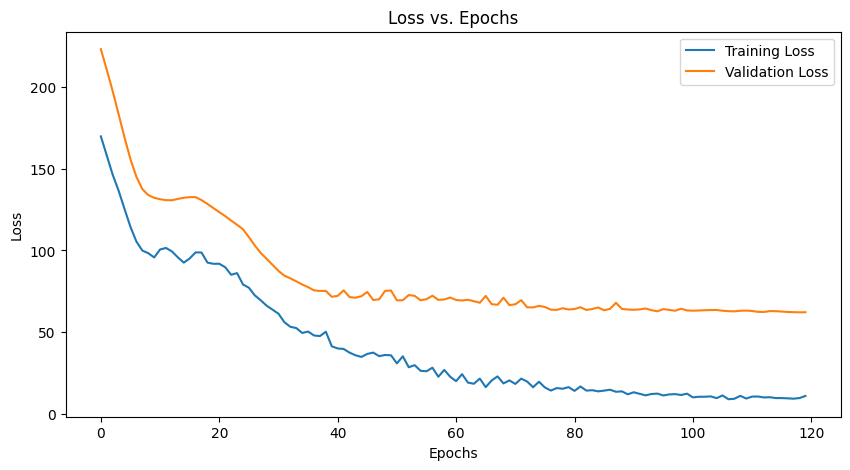

In [ ]:
num_epochs = 20
dino_model4.freeze_params()
dino_L4_trn_losses, dino_L4_vld_losses = train_model(dino_model4, dino_L4_trn_losses, dino_L4_vld_losses, num_epochs)


plot(dino_L4_trn_losses, dino_L4_vld_losses)

**No fine tuning - only cutsom head gets trained**

Epoch: 1: 
Train Loss: 172.8492, Val Loss: 224.0620
Epoch: 2: 
Train Loss: 160.4652, Val Loss: 210.0870
Epoch: 3: 
Train Loss: 148.0480, Val Loss: 195.7352
Epoch: 4: 
Train Loss: 136.0732, Val Loss: 181.2423
Epoch: 5: 
Train Loss: 124.8578, Val Loss: 166.8657
Epoch: 6: 
Train Loss: 115.0433, Val Loss: 153.8549
Epoch: 7: 
Train Loss: 107.8489, Val Loss: 143.8228
Epoch: 8: 
Train Loss: 103.5687, Val Loss: 137.5445
Epoch: 9: 
Train Loss: 99.7615, Val Loss: 134.2408
Epoch: 10: 
Train Loss: 98.6832, Val Loss: 132.8379
Epoch: 11: 
Train Loss: 100.1879, Val Loss: 132.1312
Epoch: 12: 
Train Loss: 100.9935, Val Loss: 131.7546
Epoch: 13: 
Train Loss: 97.6890, Val Loss: 131.7067
Epoch: 14: 
Train Loss: 95.8429, Val Loss: 131.8221
Epoch: 15: 
Train Loss: 94.0343, Val Loss: 132.2018
Epoch: 16: 
Train Loss: 96.0597, Val Loss: 132.5062
Epoch: 17: 
Train Loss: 98.6573, Val Loss: 132.5668
Epoch: 18: 
Train Loss: 96.1319, Val Loss: 132.4155
Epoch: 19: 
Train Loss: 97.3157, Val Loss: 132.2681
Epoch: 20: 

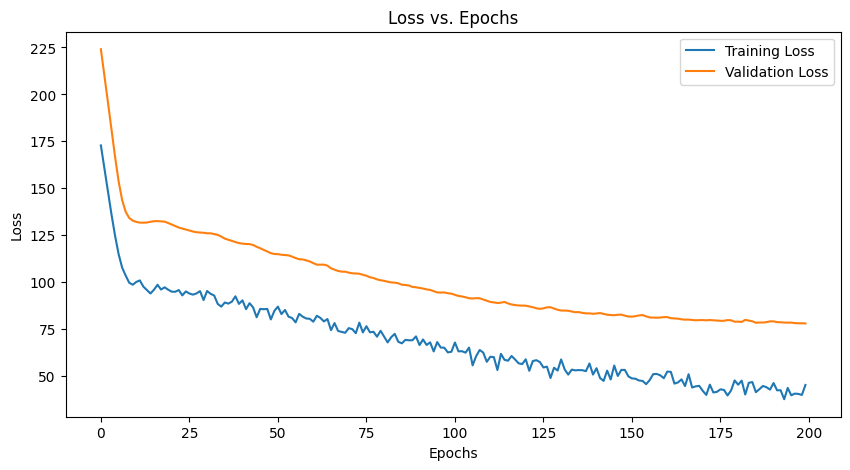

In [ ]:
num_epochs = 200
dino_model3 = CustomDinoV2Model(dino_model_name, D=0.5)
dino_L3_trn_losses = []
dino_L3_vld_losses = []
dino_L3_trn_losses, dino_L3_vld_losses = train_model(dino_model3, dino_L3_trn_losses, dino_L3_vld_losses, num_epochs)
plot(dino_L3_trn_losses, dino_L3_vld_losses)

**1. Training Head**

**2. Fine tuning the DinoV2 with LoRA**

Epoch: 1: 
Train Loss: 174.5144, Val Loss: 227.1284
Epoch: 2: 
Train Loss: 163.1766, Val Loss: 213.4177
Epoch: 3: 
Train Loss: 150.1902, Val Loss: 200.0429
Epoch: 4: 
Train Loss: 139.8592, Val Loss: 186.0332
Epoch: 5: 
Train Loss: 129.4594, Val Loss: 171.8489
Epoch: 6: 
Train Loss: 118.5897, Val Loss: 158.1930
Epoch: 7: 
Train Loss: 109.8841, Val Loss: 146.7726
Epoch: 8: 
Train Loss: 102.5600, Val Loss: 138.5733
Epoch: 9: 
Train Loss: 98.2784, Val Loss: 134.2679
Epoch: 10: 
Train Loss: 97.4556, Val Loss: 132.4554
Epoch: 11: 
Train Loss: 101.2517, Val Loss: 131.6928
Epoch: 12: 
Train Loss: 99.8164, Val Loss: 131.2609
Epoch: 13: 
Train Loss: 98.1060, Val Loss: 131.0249
Epoch: 14: 
Train Loss: 95.2539, Val Loss: 131.2084
Epoch: 15: 
Train Loss: 102.9949, Val Loss: 131.7707
Epoch: 16: 
Train Loss: 95.3196, Val Loss: 132.3169
Epoch: 17: 
Train Loss: 94.4189, Val Loss: 132.7659
Epoch: 18: 
Train Loss: 100.1205, Val Loss: 133.1517
Epoch: 19: 
Train Loss: 91.9957, Val Loss: 132.7486
Epoch: 20:

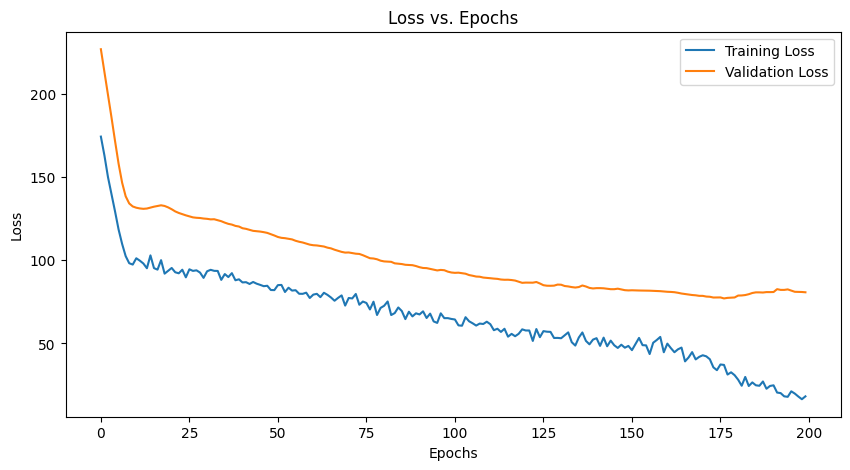

In [ ]:
dino_model = CustomDinoV2Model(dino_model_name, D=0.5)
dino_trn_losses = []
dino_vld_losses = []

num_epochs = 150
dino_trn_losses, dino_vld_losses = train_model(dino_model, dino_trn_losses, dino_vld_losses, num_epochs)

dino_model.unfreeze_params()
dino_L_trn_losses = []
dino_L_vld_losses = []
num_epochs = 50
target_modules = {
        f"dino_model.encoder.layer.{i}.attention.attention.key" for i in range(1, len(dino_model.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.attention.attention.query" for i in range(1, len(dino_model.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.attention.attention.value" for i in range(1, len(dino_model.dino_model.encoder.layer))
    } | {
        f"dino_model.embeddings.patch_embeddings.projection"
    } | {
        f"dino_model.encoder.layer.{i}.attention.output.dense" for i in range(1, len(dino_model.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.mlp.fc1" for i in range(1, len(dino_model.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.mlp.fc2" for i in range(1, len(dino_model.dino_model.encoder.layer))
    }  | {f"custom_head.0"}| {f"custom_head.4"}| {f"custom_head.8"}

dino_L_trn_losses, dino_L_vld_losses = train_model_lora(dino_model, dino_L_trn_losses, dino_L_vld_losses, num_epochs = num_epochs, target_modules = target_modules, ver = "sep_lora")
plot(dino_trn_losses + dino_L_trn_losses, dino_vld_losses + dino_L_vld_losses)

**Training Custom_head and Fine_tuning DinoV2 simultanosly**

Test

trainable params: 2,114,018 || all params: 89,581,156 || trainable%: 2.3599
Epoch: 1: 
Train Loss: 177.1416, Val Loss: 229.8791
Epoch: 2: 
Train Loss: 166.0567, Val Loss: 217.0555
Epoch: 3: 
Train Loss: 156.3916, Val Loss: 204.3883
Epoch: 4: 
Train Loss: 144.4432, Val Loss: 190.8968
Epoch: 5: 
Train Loss: 133.3886, Val Loss: 176.7553
Epoch: 6: 
Train Loss: 122.7955, Val Loss: 162.9220
Epoch: 7: 
Train Loss: 110.4575, Val Loss: 150.6543
Epoch: 8: 
Train Loss: 105.1741, Val Loss: 141.4652
Epoch: 9: 
Train Loss: 95.8839, Val Loss: 135.6491
Epoch: 10: 
Train Loss: 95.7792, Val Loss: 132.9615
Epoch: 11: 
Train Loss: 99.9676, Val Loss: 131.8232
Epoch: 12: 
Train Loss: 99.6408, Val Loss: 131.0192
Epoch: 13: 
Train Loss: 96.6358, Val Loss: 130.3511
Epoch: 14: 
Train Loss: 94.5352, Val Loss: 130.2300
Epoch: 15: 
Train Loss: 99.7890, Val Loss: 130.8983
Epoch: 16: 
Train Loss: 98.6840, Val Loss: 131.7490
Epoch: 17: 
Train Loss: 94.7210, Val Loss: 131.9529
Epoch: 18: 
Train Loss: 95.5642, Val Loss

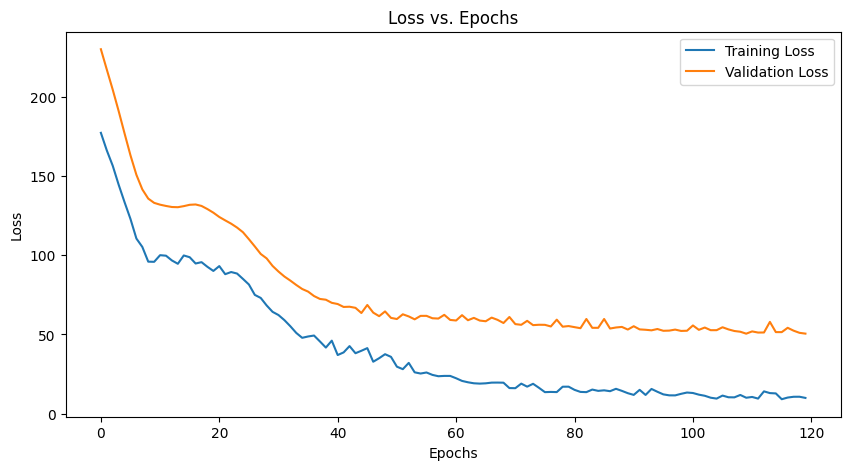

In [ ]:
dino_model2 = CustomDinoV2Model(dino_model_name, D=0.5)
dino_model2.unfreeze_params()
dino_L2_trn_losses = []
dino_L2_vld_losses = []
num_epochs = 120
modules_to_save=["custom_head"]
target_modules = {
        f"dino_model.encoder.layer.{i}.attention.attention.key" for i in range(1, len(dino_model2.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.attention.attention.query" for i in range(1, len(dino_model2.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.attention.attention.value" for i in range(1, len(dino_model2.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.attention.output.dense" for i in range(1, len(dino_model2.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.mlp.fc1" for i in range(1, len(dino_model2.dino_model.encoder.layer))
    } | {
        f"dino_model.encoder.layer.{i}.mlp.fc2" for i in range(1, len(dino_model2.dino_model.encoder.layer))
    } | { "dino_model.embeddings.patch_embeddings.projection"}
dino_L2_trn_losses, dino_L2_vld_losses = train_model_lora(dino_model2, dino_L2_trn_losses, dino_L2_vld_losses, num_epochs, target_modules = target_modules, modules_to_save=modules_to_save,  ver = "combined_lora")
plot(dino_L2_trn_losses, dino_L2_vld_losses)




**Testing models in relative to stiffness size**

In [ ]:
import torch
from torch.nn.functional import mse_loss

def test_sample(model, dataloader, device):
    model.eval()  # Set model to evaluation mode

    # Get a single sample from the validation set
    images, true_stiffness_vectors = next(iter(dataloader))
    images, true_stiffness_vectors = images.to(device), true_stiffness_vectors.to(device)

    # Predict the stiffness vector
    with torch.no_grad():
        predicted_stiffness_vectors = model(images)

    # Calculate RMSE
    criterion = nn.MSELoss()
    loss = criterion(predicted_stiffness_vectors, true_stiffness_vectors).float()

    rmse = torch.sqrt(loss)

    # Calculate L2 norm of the true stiffness vector
    l2_norm = torch.linalg.norm(true_stiffness_vectors, ord=2, dim=1)

    # Calculate relative error (as a percentage)
    relative_error = (rmse / l2_norm) * 100

    return relative_error.mean()  # Return the error as a percentage


relative_error_percentage = test_sample(dino_model, all_test_loader, device)
print(f"Dino Model \nRelative error percentage: {relative_error_percentage}%")

relative_error_percentage = test_sample(dino_model2, all_test_loader, device)
print(f"Dino Model2 \nRelative error percentage: {relative_error_percentage}%")

relative_error_percentage = test_sample(dino_model3, all_test_loader, device)
print(f"Dino Model3 \nRelative error percentage: {relative_error_percentage}%")

relative_error_percentage = test_sample(dino_model4, all_test_loader, device)
print(f"Dino Model4 \nRelative error percentage: {relative_error_percentage}%")

Dino Model 
Relative error percentage: 233.01573181152344%
Dino Model2 
Relative error percentage: 185.77499389648438%
Dino Model3 
Relative error percentage: 231.03944396972656%
Dino Model4 
Relative error percentage: 206.08204650878906%


Vit Reference

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,439,618 || all params: 88,715,524 || trainable%: 1.6227
Epoch: 1: 
Train Loss: 172.7797, Val Loss: 231.0040
Epoch: 2: 
Train Loss: 166.4194, Val Loss: 223.1114
Epoch: 3: 
Train Loss: 159.9727, Val Loss: 214.2765
Epoch: 4: 
Train Loss: 152.3564, Val Loss: 204.1789
Epoch: 5: 
Train Loss: 143.7613, Val Loss: 192.9609
Epoch: 6: 
Train Loss: 132.5217, Val Loss: 180.9406
Epoch: 7: 
Train Loss: 123.9575, Val Loss: 168.6886
Epoch: 8: 
Train Loss: 114.4288, Val Loss: 157.0076
Epoch: 9: 
Train Loss: 107.8297, Val Loss: 146.9954
Epoch: 10: 
Train Loss: 98.7666, Val Loss: 139.3891
Epoch: 11: 
Train Loss: 96.6687, Val Loss: 134.6529
Epoch: 12: 
Train Loss: 94.7096, Val Loss: 132.3479
Epoch: 13: 
Train Loss: 97.4447, Val Loss: 131.2173
Epoch: 14: 
Train Loss: 94.2793, Val Loss: 130.4629
Epoch: 15: 
Train Loss: 97.6332, Val Loss: 129.8187
Epoch: 16: 
Train Loss: 97.0924, Val Loss: 129.4295
Epoch: 17: 
Train Loss: 94.5532, Val Loss: 129.4594
Epoch: 18: 
Train Loss: 92.7305, Val Los

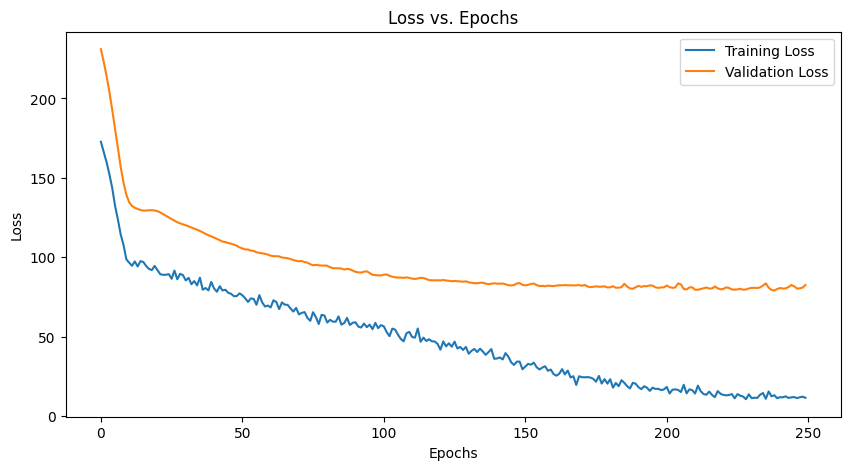

In [ ]:
vit_model_name = "google/vit-base-patch16-224"
vit_model = CustomViTModel(vit_model_name)

vit_trn_losses = []
vit_vld_losses = []
vit_model.unfreeze_params()

num_epochs = 250
modules_to_save=["custom_head"]
target_modules = {
        f"vit_model.encoder.layer.{i}.attention.attention.key" for i in range(1, len(vit_model.vit_model.encoder.layer))
    } | {
        f"vit_model.encoder.layer.{i}.attention.attention.query" for i in range(1, len(vit_model.vit_model.encoder.layer))
    } | {
        f"vit_model.encoder.layer.{i}.attention.attention.value" for i in range(1, len(vit_model.vit_model.encoder.layer))
    } | {
        f"vit_model.encoder.layer.{i}.attention.output.dense" for i in range(1, len(vit_model.vit_model.encoder.layer))
    } | {
        f"vit_model.encoder.layer.{i}.mlp.fc1" for i in range(1, len(vit_model.vit_model.encoder.layer))
    } | {
        f"vit_model.encoder.layer.{i}.mlp.fc2" for i in range(1, len(vit_model.vit_model.encoder.layer))
    } | { "vit_model.embeddings.patch_embeddings.projection"}
vit_trn_losses, vit_vld_losses = train_model_lora(vit_model, vit_trn_losses, vit_vld_losses, num_epochs, target_modules = target_modules, modules_to_save=modules_to_save,  ver = "combined_lora")
plot(vit_trn_losses, vit_vld_losses)


